<a href="https://colab.research.google.com/github/ehpub/KFQ_DL_2023-/blob/main/2023_kfq_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EB%94%A5%EB%93%9C%EB%A6%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 교재: https://www.gilbut.co.kr/book/view?bookcode=BN003496

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

440742/440742 [==============================] - 0s 0us/step


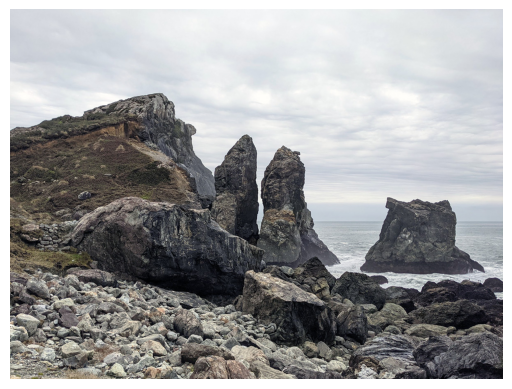

In [ ]:
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))
plt.show()

In [ ]:
from tensorflow.keras.applications import inception_v3

In [ ]:
from keras import applications

In [ ]:
dir(applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'ResNetRS101',
 'ResNetRS152',
 'ResNetRS200',
 'ResNetRS270',
 'ResNetRS350',
 'ResNetRS420',
 'ResNetRS50',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'convnext',
 'densenet',
 'efficientnet',
 'efficientnet_v2',
 '

In [ ]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [ ]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

In [ ]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [ ]:
import tensorflow as tf

In [ ]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

In [ ]:
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... 스텝 {i}에서 손실 값: {loss:.2f}")
    return image

In [ ]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [ ]:
import numpy as np

In [ ]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img += 1.0
    img *= 127.5
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"{shape} 크기의 {i}번째 옥타브 처리")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

(459, 612) 크기의 0번째 옥타브 처리
... 스텝 0에서 손실 값: 0.80
... 스텝 1에서 손실 값: 1.07
... 스텝 2에서 손실 값: 1.44
... 스텝 3에서 손실 값: 1.82
... 스텝 4에서 손실 값: 2.16
... 스텝 5에서 손실 값: 2.49
... 스텝 6에서 손실 값: 2.85
... 스텝 7에서 손실 값: 3.15
... 스텝 8에서 손실 값: 3.52
... 스텝 9에서 손실 값: 3.83
... 스텝 10에서 손실 값: 4.20
... 스텝 11에서 손실 값: 4.62
... 스텝 12에서 손실 값: 4.94
... 스텝 13에서 손실 값: 5.34
... 스텝 14에서 손실 값: 5.71
... 스텝 15에서 손실 값: 6.04
... 스텝 16에서 손실 값: 6.43
... 스텝 17에서 손실 값: 6.77
... 스텝 18에서 손실 값: 7.08
... 스텝 19에서 손실 값: 7.38
... 스텝 20에서 손실 값: 7.74
... 스텝 21에서 손실 값: 8.00
... 스텝 22에서 손실 값: 8.36
... 스텝 23에서 손실 값: 8.62
... 스텝 24에서 손실 값: 8.97
... 스텝 25에서 손실 값: 9.20
... 스텝 26에서 손실 값: 9.48
... 스텝 27에서 손실 값: 9.76
... 스텝 28에서 손실 값: 10.03
... 스텝 29에서 손실 값: 10.26
(642, 857) 크기의 1번째 옥타브 처리
... 스텝 0에서 손실 값: 1.60
... 스텝 1에서 손실 값: 2.63
... 스텝 2에서 손실 값: 3.42
... 스텝 3에서 손실 값: 4.00
... 스텝 4에서 손실 값: 4.55
... 스텝 5에서 손실 값: 5.02
... 스텝 6에서 손실 값: 5.47
... 스텝 7에서 손실 값: 5.87
... 스텝 8에서 손실 값: 6.28
... 스텝 9에서 손실 값: 6.64
... 스텝 10에서 손실 값: 7.02
... 스텝 11에서 손실 값: 7.34


In [ ]:
import cv2
import matplotlib.pyplot as plt

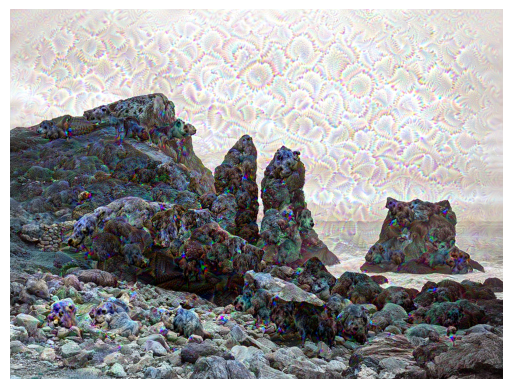

In [ ]:
di = cv2.imread('dream.png',cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(di)
plt.show()